In [ ]:
# Imports

import numpy as np
import networkx as nx
import sys
import json
from scipy.integrate import solve_ivp
import pandas as pd
import scipy
import plotly.express as px
from plotly.colors import label_rgb

from pyDowker import DowkerComplex
import matplotlib.pyplot as plt
import gudhi as gd

# Data Generation

This basically uses Kristian's Github files for the time series data, and his function from the tutorial for the Lorenz dynamical system. Each of these eventually outputs a time series. 

In [2]:
#Gets the Lorenz 63 data

def L63_ts():
    data = np.load('Data/Lorenz63/lorenz_10k_raw.npy').T

    return data

In [3]:
#Gets the Lorenz 96 data

def L96_ts():
    data = np.loadtxt('Data/Lorenz96/lorenz96_raw.txt')

    return data

In [4]:
# Gets the CDV data

def CDV_ts():

    data= np.fromfile('Data/CDV/cdv_deterministic.np').reshape([6,-1])

    return data

In [5]:
#Gets the JetLat data

def JetLat_ts():
    lats = np.loadtxt('Data/JetLat/jetlatitude_ERA20C_djf_1901-2010.txt')
    pc0 = np.loadtxt('Data/JetLat/pc0_ua850_ERA20C_1901-2010.txt')
    pc1 = np.loadtxt('Data/JetLat/pc1_ua850_ERA20C_1901-2010.txt')

    data = np.vstack([lats, pc0, pc1])
    
    return data

In [6]:
#Gets the Gaussian distribution data

def Gaussian_ts():
    data = np.loadtxt('Data/Gaussian/gaussian_raw.txt')

    return data

In [7]:
# This is the actual system of differential equations governing the Lorenz 63 system. 

def lorenz63(t, xyz, sigma, rho, beta, forcing=[0,0,0]):
    x, y, z = xyz #assign the dependent variables
    dxdt = sigma * (y - x) + forcing[0]
    dydt = x * (rho - z) - y + forcing[1]
    dzdt = x * y - beta * z + forcing[2]
    return [dxdt, dydt, dzdt]

In [8]:
def Lorenzfunction():

# Parameters for the Lorenz 63 system: these are the standard choices.
    sigma = 10.0
    rho = 28.0
    beta = 8.0 / 3.0

# to get the forcing function

    theta = 9  # 90 degrees
    forcing_magnitude = 4 #2.5
    forcing = [forcing_magnitude * np.cos(np.radians(theta)),
           forcing_magnitude * np.sin(np.radians(theta)),
           0]


# Define some initial condition to start at.
    initial_conditions = [-1.0, 1.0, 0.0]

# Set the timestep and the total timespan to integrate over. In this case, we integrate 50,000 timesteps
# over a time variable ranging from 0 to 40.
    t_span = (0, 40)
    t_eval = np.linspace(*t_span, 50000)


# Integrate the system using solve_ivp from scipy
    sol = solve_ivp(lorenz63, t_span, initial_conditions, t_eval=t_eval, args=(sigma, rho, beta, forcing))

    return sol.y

# Bin the Time Series

In [9]:
#Inputs: ts - a 2D np array of any shape. Probably a time series. 
# b - the number of bins in each dimension
#Output: bins - A dictionary of arrays that contains the boundaries of the bins in each dimension

def get_bins(ts,b):
    d,n = ts.shape
    bins = {}
    for i in range(d):
        top = max(ts[i])
        bot = min(ts[i])
        step = (top - bot)/b
        ibins = []
        for j in range(b+1):
            ibins.append(bot+j*step)
        bins[i] = ibins
    return bins

In [10]:
#Inputs: ts - time series
#bins - the partition of each dimension into its bins
#b - number of bins in each dimension

#Output: binseq - a 1D array the length of ts that lists which bin each entry in the time series is in

def bin_sequence(ts, bins, b):
    d,n = ts.shape
    binseq = np.zeros((n))
    for i in range(n):
        bin_n = 0
        for j in range(d):
            k = 1
            while k <= b:
                if ts[j,i] <= bins[j][k]:
                    bin_n += (k-1)*(b**j)
                    k = b + 1
                else: 
                    k = k + 1 
        binseq[i] = bin_n

    return binseq

In [11]:
#This function combines the splitting space into bins and the binning

#Inputs: sol - a time series
#bin_param - a number of bins in each dimension
#Outputs: the binning sequence of the time series

def bin_sol(sol, bin_param):
    B = get_bins(sol, bin_param)
    seq = bin_sequence(sol, B, bin_param)
    return seq

# Go from Bin Sequence to Graph and Matrices

In [12]:
#inputs: bin-seq - the bin sequence of the time series
#outputs: A - the adjacency matrix
# vertices - the list of vertices, enumerated as bin number

def adjacency(bin_seq):
    vertices = np.unique(bin_seq)
    order = len(vertices)
    A = np.zeros((order,order))
    for i in range(len(bin_seq)-1):
        A[np.where(vertices == bin_seq[i]),np.where(vertices == bin_seq[i+1])] += 1
    return A, vertices

In [13]:
## inputs - the adjacency matrix
##output - the probability markov chain matrix

def prob_matrix(A):
    P = np.zeros(A.shape)
    for i in range(A.shape[0]):
        P[i] = A[i]/sum(A[i])
    
    return P

In [14]:
# inputs: A - the adjacency matrix
# vertices - the list of vertices, which are the bin numbers
# loops - whether or not to keep the self-loops in the graph, I am going to do something with this eventually when I include some sort of markovian random walk diffusion distance 
#Output: G - a networkx digraph


def digraph(A, vertices, loops: bool):
    if loops == False:
        np.fill_diagonal(A,0)
        G = nx.DiGraph(A)
    elif loops == True:
        G = nx.DiGraph(A)
    for i in range(len(G.nodes)):
       G.nodes[i]['bin'] = vertices[i]

    return G

In [15]:
#This is a combination of the previous two functions

#inputs: seq - the sequence of bins for the time series
#loops - boolean to keep the self-loops or not
#outputs: H - the digraph!

def construct_digraph(seq, loops = False):
    A, vertices = adjacency(seq)
    H = digraph(A,vertices,loops)
    return H

In [16]:
#Inputs: G - a networkx graph
# method - the way you want to measure distance on the graph
# Outputs: D - a distance matrix

def distance_matrix(G, method = 'unweighted_shortest_path'):
    if method == 'unweighted_shortest_path':
        lengths = dict(nx.all_pairs_shortest_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                    D[key,item] = lengths[key][item]
    
    if method == 'weighted_shortest_path':
        w = nx.get_edge_attributes(G,'weight')
        for key in w:
            w[key] = 1/w[key]
        nx.set_edge_attributes(G,w,name='weight')
        lengths = dict(nx.all_pairs_dijkstra_path_length(G))
        D = np.full((len(lengths),len(lengths)),1000,dtype=float) # was -1 default
        for key in lengths:
            for item in lengths[key]:
                if lengths[key][item] != 0:
                    D[key,item] = lengths[key][item]
                elif lengths[key][item] == 0:
                    D[key,item] = 0

    return D

# Work on Visualizations

In [17]:
# function to convert a bin number into the coordinates in terms of bin number in each dimension
# bins in form a1 b^0 + a2 b^1 + ... + an b^n for n dimensions and b=bins_per_dim. Hoping to extract {a_i}_i
# takes as input the bin number, bin, the bins per dimension, bins_per_dim and the number of dimensions, num_of_dims
def bin_to_axis_bins(bin, bins_per_dim, num_of_dims):
    remainder = bin.astype(int)
    coords = np.zeros(num_of_dims)
    # initializes the first coordinate as the input bin number modulo number of bins per axis/dimension
    coords[0] = bin % bins_per_dim
    # for loop for the rest of the coordinates
    for dim in range(1, num_of_dims):
        # calculates the remainder by removing previously calculated coordinates
        remainder = (remainder - coords[dim-1])/bins_per_dim
        # checking if there's this dim has an entry to calculate
        if remainder > 0:
            # modulo to find the coordinate
            coords[dim] = (remainder) % bins_per_dim  
    
    return coords # returning the bins along all dimensions

In [18]:
# mapping vertices onto bins in state space
# vert[i] is the bin of vertex i
# want to go from bin number to axial bin identifiers
# inputs are a graph, a number of bins, and a dimension

def bin_pos(G, b=10, d=3):

    pos = {}
    vx_axis_bins = []
    for i in G.nodes():
        vx_axis_bins.append(bin_to_axis_bins(bin = G.nodes[i]['bin'], bins_per_dim = b, num_of_dims=d))
        pos[i] = np.array([vx_axis_bins[i][0]-vx_axis_bins[i][2]*0.5, vx_axis_bins[i][1]]-vx_axis_bins[i][2]*0.3)
    
    return pos
    

In [19]:
# this functions takes an index for the cycle data and the digraph on which to plot

def color_cycle_digraph(index, H, data):
    color_map = ['gray']*len(H.nodes)
    for node in data[index]:
        color_map[node[1]] = 'red'
        color_map[node[0]] = 'red'

    return color_map
                

In [20]:
def color_scheme(num):
   
   k = int(num)
   if k < 10:
       string = '0' + '0' + str(k)
   elif k < 100:
       string = '0' + str(k)
   else:
       string = str(k)
   as_list = [float(x)/10 * 255 for x in string]

   return as_list

In [21]:
def cycle_color_seq(index, H, data, bin_seq):
    color_bins = []
    for pair in data[index]:
        color_bins.append(H.nodes[pair[0]]['bin'])
        color_bins.append(H.nodes[pair[1]]['bin'])

    color_seq = [x if x in color_bins else 1 for x in bin_seq]
    #eventually need to get rgb color here, but somehow just for cycle
    colors = [label_rgb(color_scheme(x)) for x in color_seq]

    return colors

In [22]:
def color_seq(bin_seq):

    color_seq = [color_scheme(x) for x in bin_seq]
    colors = [label_rgb(x) for x in color_seq]

    return colors

In [23]:
# plot 3D phase space, colored by bin
# Inputs: ts - the time series in 3 dimensions
# Outputs: a plotly figure, you'll need to add fig.show() probably

def plot_phase_space_3d(ts, colors):

    fig = px.scatter_3d(x = ts[0], y = ts[1], z = ts[2], color=colors)
    fig.update_traces(marker=dict(size=1))
    
    return fig

# Interpreting JSON file that has generators

In [24]:
# Load json file

def process_json(fname: str):

    f = open(fname)
    data = json.load(f)
    new_data = []
    for gen_seq in data:
        new_gen_seq = []
        for gen in gen_seq:
            newgen = [int(x)-1 for x in gen]
            new_gen_seq.append(newgen)
        new_data.append(new_gen_seq)

    return new_data

# Testing 

In [25]:
data = Lorenzfunction()

In [26]:
data

array([[-1.00000000e+00, -9.81005423e-01, -9.62339546e-01, ...,
         5.86185955e+00,  5.87661803e+00,  5.89149794e+00],
       [ 1.00000000e+00,  9.77522209e-01,  9.55483420e-01, ...,
         7.30371183e+00,  7.33377929e+00,  7.36395688e+00],
       [ 0.00000000e+00, -7.82648490e-04, -1.53146919e-03, ...,
         2.04602500e+01,  2.04509754e+01,  2.04419490e+01]])

In [27]:
bin_seq = bin_sol(data,10)

In [28]:
A = adjacency(bin_seq)[0]

In [29]:
A.shape[0]

186

In [30]:
prob_matrix(A)

array([[0.99669967, 0.00330033, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.94736842, 0.05263158, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.99099099, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.94117647, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05882353, 0.94117647,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.11111111,
        0.88888889]])

In [31]:
B = np.zeros(A.shape)

In [32]:
for i in range(len(A)):
    B[i] = A[i]/sum(A[i])

In [33]:
B

array([[0.99669967, 0.00330033, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.94736842, 0.05263158, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.99099099, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.94117647, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05882353, 0.94117647,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.11111111,
        0.88888889]])

In [36]:
G = construct_digraph(bin_seq)
D = distance_matrix(G)
print(D.shape)
print(D)

(186, 186)
[[   0.    1.    2. ...   22.   21.   20.]
 [1000.    0.    1. ...   21.   20.   19.]
 [1000. 1000.    0. ...   20.   19.   18.]
 ...
 [1000. 1000. 1000. ...    0. 1000. 1000.]
 [1000. 1000. 1000. ...    1.    0. 1000.]
 [1000. 1000. 1000. ...    2.    1.    0.]]


# Use pyDowker instead of MATLAB now

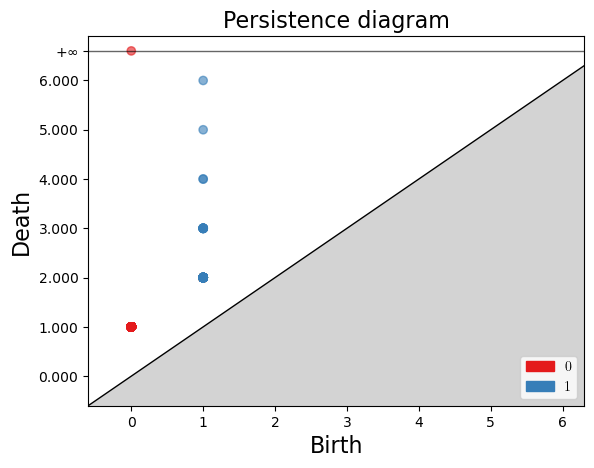

Bars:  [(1, (1.0, 6.0)), (1, (1.0, 5.0)), (1, (1.0, 4.0)), (1, (1.0, 4.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 3.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1

In [ ]:
MNeighbor = DowkerComplex.DowkerComplex(D).create_simplex_tree(filtration='Sublevel', max_dimension=2)
dgms = MNeighbor.persistence()
f,ax = plt.subplots()
gd.plot_persistence_diagram(dgms, axes=ax)
plt.show()

print("Bars: ",dgms)

## ... now assume that gens.json was obtained using the above distance matrix

In [38]:
#gens = process_json('Dowker/gens.json')

In [39]:
#nx.draw(G,pos=bin_pos(G), node_size=25 ,node_color=color_cycle_digraph(-1,G,gens))

In [40]:
#fig = plot_phase_space_3d(data,color_seq(bin_seq))

In [41]:
#fig.show()

In [42]:
#fig2 = plot_phase_space_3d(data,cycle_color_seq(-1,G,gens,bin_seq))

In [43]:
#fig2.show()